In [1]:
import pandas as pd
import numpy as np
import torch
import pandas_profiling

In [2]:
dataset=pd.read_csv('./dataset/train.csv')
testset=pd.read_csv('./dataset/test.csv')

In [3]:
def concatenate(train,test):
    nullset=pd.DataFrame()
    for i in range(1,46):
        nullset=pd.concat([nullset,pd.concat([train.query('Store=={}'.format(i)),test.query('Store=={}'.format(i))])])
    return nullset

In [4]:
concatdata=concatenate(dataset,testset)

In [5]:
concatdata["Date"] = pd.to_datetime(concatdata['Date'],yearfirst=True,dayfirst=True)

In [6]:
concatdata.drop(columns='id',inplace=True)

프로모션 1~5 변수가 2/3정도 결측이 되어 있다.

In [7]:
dataset.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

공휴일에 따른 매출액의 유의미한 차이 발생

In [8]:
dataset.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    1.041784e+06
True     1.122888e+06
Name: Weekly_Sales, dtype: float64

In [9]:
concatdata['Year']=concatdata['Date'].dt.year
concatdata['Month']=concatdata['Date'].dt.month

~7: Low unemployment
7~11: Mid Unemployment
11~: High unemployment 

(array([ 2.,  4.,  8., 15., 10.,  1.,  2.,  0.,  0.,  3.]),
 array([ 4.8147482 ,  5.65331727,  6.49188633,  7.3304554 ,  8.16902446,
         9.00759353,  9.84616259, 10.68473165, 11.52330072, 12.36186978,
        13.20043885]),
 <BarContainer object of 10 artists>)

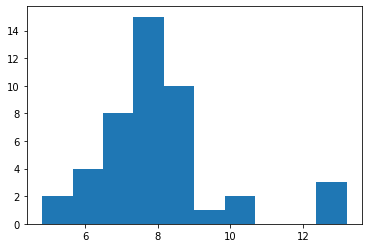

In [10]:
import matplotlib.pyplot as plt
plt.hist(dataset.groupby('Store')['Unemployment'].mean())

In [11]:
unemployment_class=pd.DataFrame(dataset.groupby('Store')['Unemployment'].mean()).reset_index()

In [12]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

C:\Users\icako\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=9), k=None)

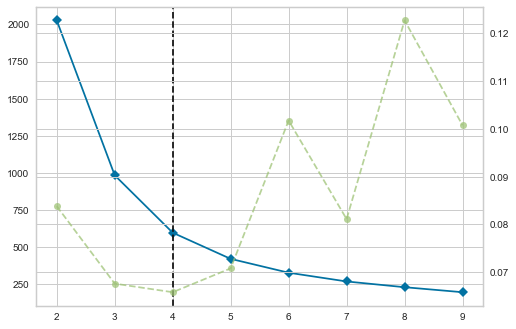

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(unemployment_class)

In [14]:
model_usage = KMeans(n_clusters = 4)

# 정규화된 데이터에 학습
model_usage.fit(unemployment_class)

KMeans(n_clusters=4)

In [15]:
unemployment_class['Unemployment_Class']=model_usage.fit_predict(unemployment_class)
unemployment_class.drop(columns='Unemployment',inplace=True)

In [16]:
dataset=pd.merge(dataset,unemployment_class,on='Store',how='left')
concatdata=pd.merge(concatdata,unemployment_class,on='Store',how='left')

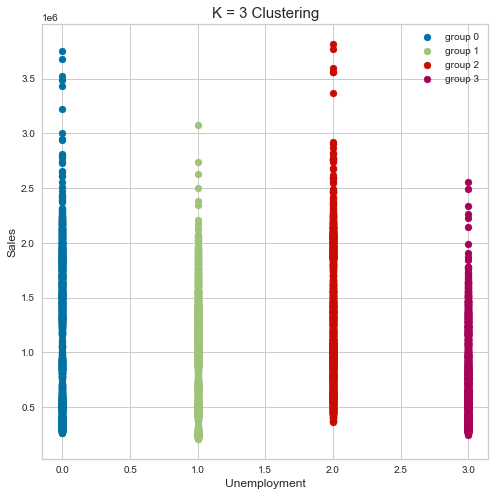

In [17]:
plt.figure(figsize = (8, 8))

for i in range(4):
    plt.scatter(dataset.loc[dataset['Unemployment_Class'] == i, 'Unemployment_Class'], 
                dataset.loc[dataset['Unemployment_Class'] == i, 'Weekly_Sales'], 
                label = 'group ' + str(i))

plt.legend()
plt.title('K = %d Clustering'%3 , size = 15)
plt.xlabel('Unemployment', size = 12)
plt.ylabel('Sales', size = 12)

plt.show()

In [18]:
salesperclass=dataset.groupby('Unemployment_Class')[['Weekly_Sales']].mean().reset_index()

In [19]:
salesperclass

,Unemployment_Class,Weekly_Sales
0,0,1.195373e+06
1,1,9.944029e+05
2,2,1.241599e+06
3,3,7.414675e+05


실업률 class별 평균 주간 소비량에 명확한 차이가 발생하고 있다.

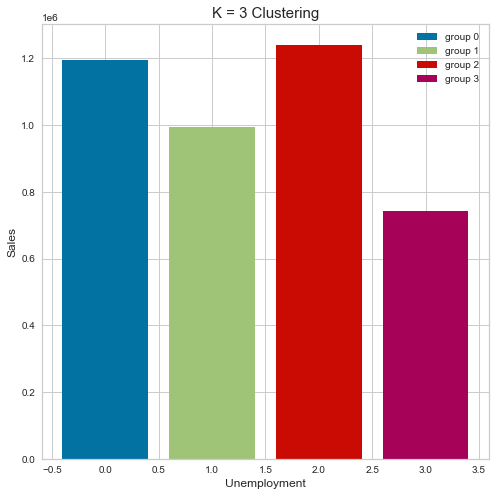

In [20]:
plt.figure(figsize = (8, 8))

for i in range(4):
    plt.bar(salesperclass.loc[salesperclass['Unemployment_Class'] == i, 'Unemployment_Class'], 
                salesperclass.loc[salesperclass['Unemployment_Class'] == i, 'Weekly_Sales'], 
                label = 'group ' + str(i))

plt.legend()
plt.title('K = %d Clustering'%3 , size = 15)
plt.xlabel('Unemployment', size = 12)
plt.ylabel('Sales', size = 12)

plt.show()

In [21]:
promotions=['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4','Promotion5']

In [22]:
def fill_na(data):
    data.loc[(data['Date'] < '2011-11-11'),promotions]=0
    #2011년 11월 11일 이전에 promotion 변수 집계 시작. 이전 날짜 값에 0 대체
    data_x = data.drop(columns='Weekly_Sales').interpolate(method='bfill')
    outputs=pd.concat([data_x,data['Weekly_Sales']],axis=1)
    outputs.loc[outputs['Promotion2']<0,'Promotion2']=0
    outputs.loc[outputs['Promotion3']<0,'Promotion3']=0
    return outputs

In [23]:
dataset_wona=fill_na(concatdata)

모든 매장에서 10,11,12월달에 매출액이 급격히 증가한다. 

따라서, 10,11,12월을 별도 처리하기 위한 ispeak 변수를 추가한다.

36번 매장의 경우 매출이 매년 하락중인데 이를 세밀하게 분석할 필요가 있다.

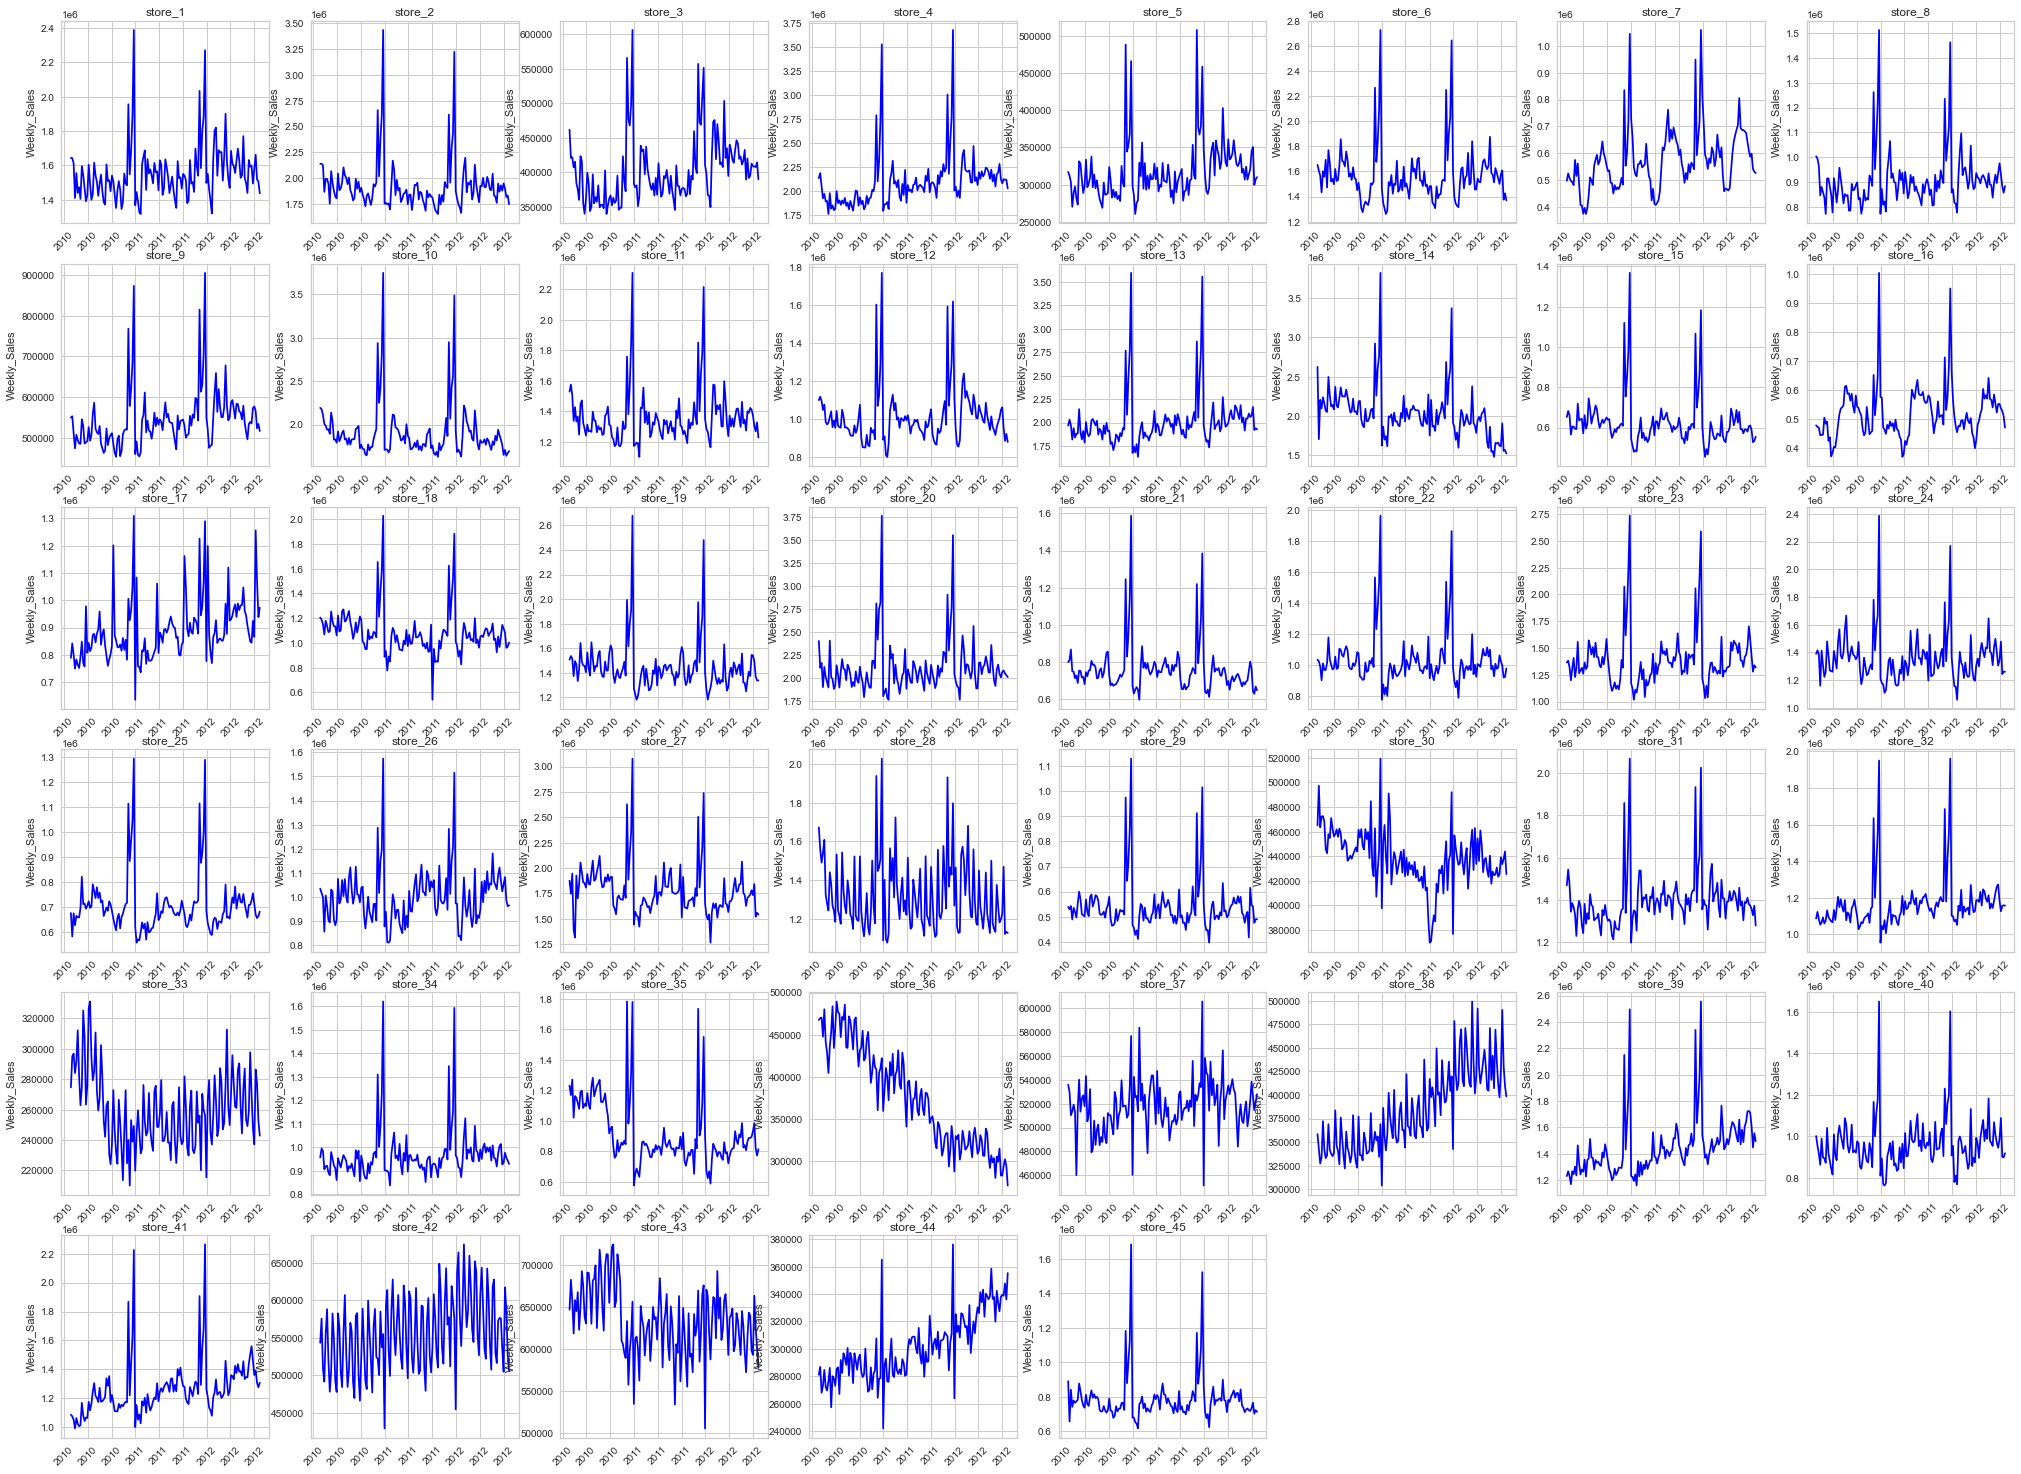

In [24]:
from matplotlib import dates

fig = plt.figure(figsize=(35,35)) 

for i in range(1,46):
    plotdf=dataset_wona.query('Store=={}'.format(i))[['Date','Weekly_Sales']]
    ax = fig.add_subplot(8,8,i) ## 그림 뼈대(프레임) 생성


    plt.title("store_{}".format(i)) 
    plt.ylabel('Weekly_Sales')
    plt.xticks(rotation=45)
    ax.xaxis.set_major_locator(dates.MonthLocator(interval = 4))
    ax.plot(plotdf["Date"], plotdf["Weekly_Sales"],marker='',label='train', color="blue")

plt.show()

In [25]:
dataset_wona['ispeak']=0
dataset_wona.loc[(dataset_wona['Month']==10)|(dataset_wona['Month']==11)|(dataset_wona['Month']==12),'ispeak']=1

In [26]:
dataset_wona.groupby('ispeak')[['Weekly_Sales']].mean()

,Weekly_Sales
ispeak,
0,1.024321e+06
1,1.144261e+06


In [27]:
train=dataset_wona.loc[dataset_wona['Date']<='2012-09-28']
test=dataset_wona.loc[dataset_wona['Date']>'2012-09-28']

지역의 실업률은 꾸준히 낮아진반면 매출액은 하락하였다.
유가가 급격하게 상승한 것이 원인으로 꼽을 수 있을 것 같다.

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

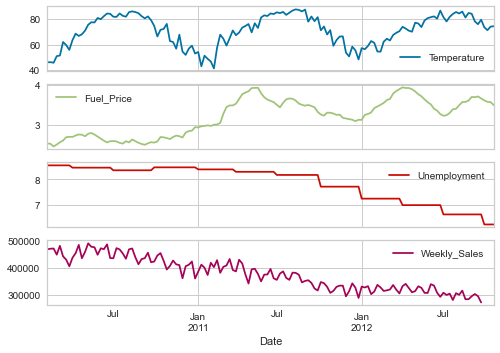

In [28]:
dataset_wona.query('Store=={}'.format(36)).set_index('Date')[[
    'Temperature', 'Fuel_Price', 'Unemployment', 'Weekly_Sales'
]].plot(subplots=True)

In [30]:
train.to_csv('./dataset/trainprocessed.csv',index=False)
test.to_csv('./dataset/test_processed.csv',index=False)

In [ ]:
cols=['Temperature','Fuel_Price','Promotion1','Promotion2','Promotion3','Promotion4','Promotion5',
     'Unemployment','IsHoliday','Weekly_Sales','Unemployment_Class','ispeak','Weekly_Sales']

train=train[cols]
train['Weekly_Sales']=np.log10(train['Weekly_Sales'])
test_x=test[cols]

In [ ]:
train

In [ ]:
train_processed=pd.get_dummies(train,columns=['Unemployment_Class'])

In [ ]:
from pycaret.regression import *

In [45]:
train_processed

,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,ispeak,Weekly_Sales,Unemployment_Class_0,Unemployment_Class_1,Unemployment_Class_2,Unemployment_Class_3
0,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,6.215820,0,6.215820,1,0,0,0
1,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,6.215362,0,6.215362,1,0,0,0
2,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,6.207356,0,6.207356,1,0,0,0
3,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,6.149135,0,6.149135,1,0,0,0
4,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,6.191676,0,6.191676,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6426,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,5.865872,0,5.865872,0,0,1,0
6427,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,5.884519,0,5.884519,0,0,1,0
6428,67.87,3.948,11407.95,92.28,4.30,3421.72,5268.92,8.684,False,5.846484,0,5.846484,0,0,1,0
6429,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,5.859190,0,5.859190,0,0,1,0


In [46]:
model = setup(train_processed, target = 'Weekly_Sales', 
              fold_shuffle=True,
              fold=15, 
              session_id=530,
              remove_multicollinearity = True,
              normalize= True,
              n_jobs = -1,
              silent = True,
              combine_rare_levels = True,
              ignore_low_variance = True )

RuntimeError: This version of PyCaret requires scikit-learn==0.23.2, got 1.0.2. Support for newer scikit-learn versions will be added in a future release.